In [1]:
load('all_polls.RData')
library(dplyr)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [2]:
# Define function create a new replicate column
rep_sample_n <- function (tbl, size, replace = FALSE, reps = 1) 
{
  n <- nrow(tbl)
  i <- unlist(replicate(reps, sample.int(n, size, replace = replace), 
                        simplify = FALSE))
  rep_tbl <- cbind(replicate = rep(1:reps, rep(size, reps)), 
                   tbl[i, ])
  dplyr::group_by(rep_tbl, replicate)
}

## RESAMPLING FROM A SAMPLE

- all_poll: Sample 30 people from the population 1000 times => should know the population => impossible in practice
- The all_polls dataset contains 1000 samples of size 30 from a population with a probability of voting for Candidate X equal to 0.6.

In [3]:
# Select one poll from which to resample: one_poll
one_poll <- all_polls %>%
  filter(poll == 1) %>%
  select(vote)

In [4]:
# Generate 1000 resamples of one_poll: one_poll_boot_30
one_poll_boot_30 <- one_poll %>%
  rep_sample_n(size = 30, replace = TRUE, reps = 1000)

In [5]:
# Compute p-hat for each poll: ex1_props
ex1_props <- all_polls %>% 
  group_by(poll) %>% 
  summarize(prop_yes = mean(vote))

# Compute p-hat* for each resampled poll: ex2_props
ex2_props <- one_poll_boot_30 %>%
  summarize(prop_yes = mean(vote))

In [6]:
# Compare variability of p-hat and p-hat*
ex1_props %>% summarize(sd(prop_yes))
ex2_props %>% summarize(sd(prop_yes))

sd(prop_yes)
0.08683128


sd(prop_yes)
0.08378487


=> p_hat is approximately the same whether we sample from population or resample from a sample

## RESAMPLE NOT THE SAME SIZE AS THE ORIGINAL DATASET

In [8]:
# Resample from one_poll with n = 3: one_poll_boot_3
one_poll_boot_3 <- one_poll %>%
  rep_sample_n(3, replace = TRUE, reps = 1000)

# Resample from one_poll with n = 300: one_poll_boot_300
one_poll_boot_300 <- one_poll %>%
  rep_sample_n(300, replace = TRUE, reps = 1000)

# Compute p-hat* for each resampled poll: ex3_props
ex3_props <- one_poll_boot_3 %>% 
  summarize(prop_yes = mean(vote))

# Compute p-hat* for each resampled poll: ex4_props
ex4_props <- one_poll_boot_300 %>% 
  summarize(prop_yes = mean(vote))

In [9]:
# Compare variability of p-hat* for n = 3 vs. n = 300
ex3_props %>% summarize(sd(prop_yes))
ex4_props %>% summarize(sd(prop_yes))

sd(prop_yes)
0.2731443


sd(prop_yes)
0.02626365


=> resampling 3 or 300 individuals with replacement from the 30-observation dataset is not a good approximation of this value.

## VISUALIZE VARIABILITY OF P-HAT

- Experiment 1: Sample (n=30) repeatedly from an extremely large population (gold standard, but unrealistic)
- Experiment 2: Resample (n=30) repeatedly with replacement from a single sample of size 30
- Experiment 3: Resample (n=3) repeatedly with replacement from a single sample of size 30
- Experiment 4: Resample (n=300) repeatedly with replacement from a single sample of size 30

In [10]:
# Recall the variability of sample proportions
ex1_props %>% summarize(sd(prop_yes))
ex2_props %>% summarize(sd(prop_yes))
ex3_props %>% summarize(sd(prop_yes))
ex4_props %>% summarize(sd(prop_yes))

sd(prop_yes)
0.08683128


sd(prop_yes)
0.08378487


sd(prop_yes)
0.2731443


sd(prop_yes)
0.02626365


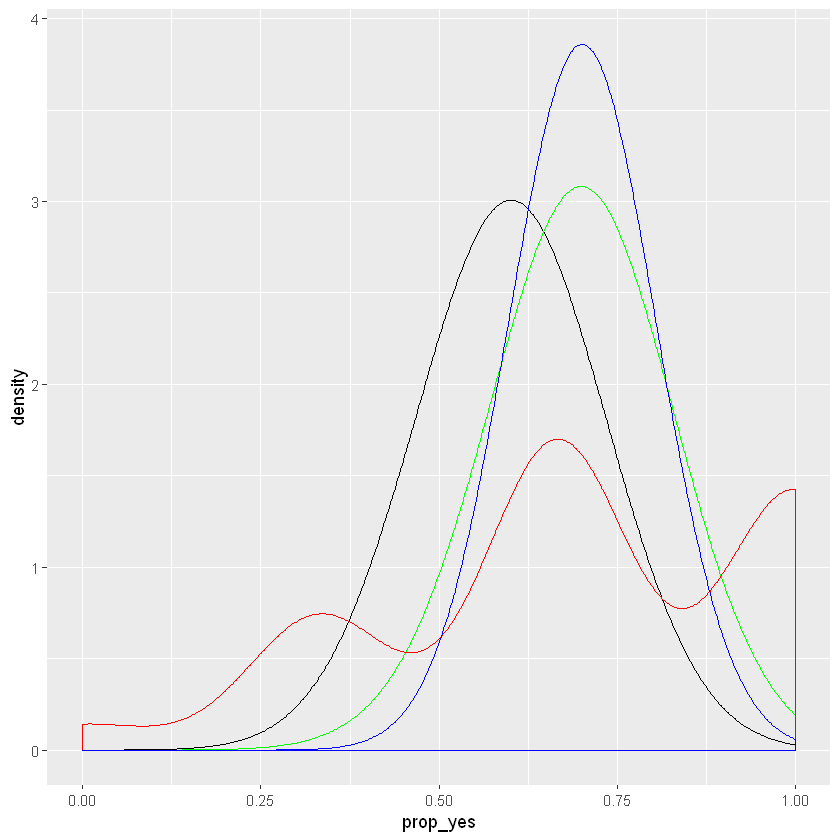

In [12]:
# Create smoothed density curves for all four experiments
library(ggplot2)

ggplot() + 
  geom_density(data = ex1_props, aes(x = prop_yes), col = "black", bw = .1) +
  geom_density(data = ex2_props, aes(x = prop_yes), col = "green", bw = .1) +
  geom_density(data = ex3_props, aes(x = prop_yes), col = "red", bw = .1) +
  geom_density(data = ex4_props, aes(x = prop_yes), col = "blue", bw = .1)

## EMPIRICAL RULE

check: if the variability of the sample proportion (called the standard error, or SE) is known, then approximately 95% of p-values (from different samples) will be within 2SE of the true population proportion.

In [13]:
# Compute proportion of votes for Candidate X: props
props <- all_polls %>%
  group_by(poll) %>% 
  summarize(prop_yes = mean(vote == 1))

In [14]:
# Proportion of polls within 2SE
props %>%
  mutate(lower = mean(prop_yes) - 2 * sd(prop_yes),
         upper = mean(prop_yes) + 2 * sd(prop_yes),
         in_CI = prop_yes > lower & prop_yes < upper) %>%
  summarize(mean(in_CI))

mean(in_CI)
0.966


=> 96.6% are within 2 standard errors of the true population parameter.

## BOOTSTRAP T-CONFIDENCE INTERVAL

In [17]:
# Again, set the one sample that was collected
one_poll <- all_polls %>%
  filter(poll == 1) %>%
  select(vote)

# Compute p-hat from one_poll: p_hat
p_hat <- mean(one_poll$vote)

# Bootstrap to find the SE of p-hat: one_poll_boot
one_poll_boot <- one_poll %>%
  rep_sample_n(30, replace = TRUE, reps = 1000) %>%
  summarize(prop_yes_boot = mean(vote == 1))

In [18]:
# Create an interval of plausible values
one_poll_boot %>%
  summarize(lower = p_hat - 2 * sd(one_poll_boot$prop_yes_boot),
            upper = p_hat + 2 * sd(one_poll_boot$prop_yes_boot))

# Find the 2.5% and 97.5% of the p-hat values for comparison
one_poll_boot %>% 
  summarize(q025_prop = quantile(prop_yes_boot, p = 0.025),
            q975_prop = quantile(prop_yes_boot, p = 0.975))

lower,upper
0.5326918,0.8673082


q025_prop,q975_prop
0.5333333,0.8666667


## SAMPLE SIZE ON BOOTSTRAP CIS

In [21]:
# Recall the bootstrap t-confidence interval
p_hat <- mean(one_poll$vote)
one_poll_boot %>%
  summarize(lower = p_hat - 2 * sd(prop_yes_boot),
            upper = p_hat + 2 * sd(prop_yes_boot))

lower,upper
0.2993584,0.6339749


In [22]:
# Collect a sample of 30 observations from the population
one_poll <- as.tbl(data.frame(vote = rbinom(30, 1, .6)))

# Resample the data using samples of size 300 (an incorrect strategy!)
one_poll_boot_300 <- one_poll %>%
  rep_sample_n(300, replace = TRUE, reps = 1000) %>%
  summarize(prop_yes_boot = mean(vote))

# Find the endpoints of the bootstrap t-confidence interval
one_poll_boot_300 %>%
  summarize(lower = p_hat - 2 * sd(prop_yes_boot),
            upper = p_hat + 2 * sd(prop_yes_boot))

lower,upper
0.4100897,0.5232436


In [23]:
# Resample the data using samples of size 3 (an incorrect strategy!)
one_poll_boot_3 <- one_poll %>%
  rep_sample_n(3, replace = TRUE, reps = 1000) %>%
  summarize(prop_yes_boot = mean(vote)) 

# Find the endpoints of the the bootstrap t-confidence interval 
one_poll_boot_3 %>%
  summarize(lower = p_hat - 2 * sd(prop_yes_boot),
            upper = p_hat + 2 * sd(prop_yes_boot))

lower,upper
-0.1081297,1.041463


## SAMPLE PROPORTION VALUE EFFECTS ON BOOTSTRAP CIS

Change true proportion from 0.6 to 0.8

In [24]:
# Collect 30 observations from a population with true proportion of 0.8
one_poll <- as.tbl(data.frame(vote = rbinom(n = 30, size = 1, prob = 0.8)))

# Compute p-hat of new sample: p_hat
p_hat <- mean(one_poll$vote)

# Resample the 30 observations (with replacement)
one_poll_boot <- one_poll %>%
  rep_sample_n(30, replace = TRUE, reps = 1000) %>%
  summarize(prop_yes_boot = mean(vote))

In [25]:
# Calculate the bootstrap t-confidence interval
one_poll_boot %>%
  summarize(lower = p_hat - 2 * sd(one_poll_boot$prop_yes_boot),
            upper = p_hat + 2 * sd(one_poll_boot$prop_yes_boot))

lower,upper
0.7889385,1.011062


=> it's narrower than previously calculated.

## PERCENTILE EFFECTS ON BOOTSTRAP CIS

In [26]:
# Calculate a 95% bootstrap percentile interval
one_poll_boot %>% 
  summarize(q025_prop = quantile(prop_yes_boot, p = .025),
            q975_prop = quantile(prop_yes_boot, p = .975))

q025_prop,q975_prop
0.8,1


In [27]:
# Calculate a 99% bootstrap percentile interval
one_poll_boot %>% 
  summarize(q005_prop = quantile(prop_yes_boot, p = .005),
            q995_prop = quantile(prop_yes_boot, p = .995))

q005_prop,q995_prop
0.7665,1


In [28]:
# Calculate a 90% bootstrap percentile interval
one_poll_boot %>% 
  summarize(q05_prop = quantile(prop_yes_boot, p = .05),
            q95_prop = quantile(prop_yes_boot, p = .95))

q05_prop,q95_prop
0.8,0.9666667
